In [15]:
import torch
# from __future__ import absolute_import
# from __future__ import print_function

from itertools import product

import argparse
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn

import gym
import torch.optim as optim
from matplotlib import pylab as plt

In [16]:
def get_z_tilde_z_samples_params(logits):  # logits = log P(b | theta)
    u = torch.rand_like(logits, device=logits.device)
    v = torch.rand_like(logits, device=logits.device)
    z = logits - torch.log(-torch.log(u))
    samples = torch.argmax(z)

    tilde_z = -torch.log(-torch.log(v)/torch.exp(logits) -
                         torch.log(v)[samples])
    tilde_z[samples] = -torch.log(-torch.log(v))[samples]

    return z, tilde_z, samples

In [17]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
from icecream.icecream import ic


class RELAX(nn.Module):

    def __init__(self, env, hidden_size=128, gamma=.99, random_seed=None):
        """
        Assumes fixed continuous observation space
        and fixed discrete action space (for now)

        :param env: target gym environment
        :param gamma: the discount factor parameter for expected reward function :float
        :param hidden_size: hiddens size for actor and critic hidden layer
        :param random_seed: random seed for experiment reproducibility :float, int, str
        """
        super().__init__()

        if random_seed:
            torch.manual_seed(random_seed)

        self.env = env
        self.gamma = gamma
        self.hidden_size = hidden_size
        self.in_size = len(env.observation_space.sample().flatten())
        self.out_size = self.env.action_space.n

        self.actor = nn.Sequential(
            nn.Linear(self.in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.out_size)
        ).double()

        self.critic = nn.Sequential(
            nn.Linear(self.in_size + self.out_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        ).double()

    def train_env_episode(self, render=False):
        """
        Runs one episode and collects critic values, expected return,
        :return: A tensor with total/expected reward, critic eval, and action information
        """
        rewards = []
        critic_vals = []
        critic_z_vals = []
        action_lp_vals = []

        observation, _ = self.env.reset()
        done = False
        while not done:
            if render:
                self.env.render()

            observation = torch.from_numpy(observation).double()

            action_logits = self.actor(observation)

            z, tilde_z, action = get_z_tilde_z_samples_params(action_logits)

            action_log_prob = F.log_softmax(action_logits)[action]

            pred = torch.squeeze(self.critic(
                torch.cat([observation, tilde_z])).view(-1))
            pred_z = torch.squeeze(self.critic(
                torch.cat([observation, z])).view(-1))

            action_lp_vals.append(action_log_prob)
            critic_vals.append(pred)
            critic_z_vals.append(pred_z)

            observation, reward, done, _, _ = self.env.step(action.item())
            rewards.append(torch.tensor(reward).double())

        with torch.no_grad():
            total_reward = sum(rewards).item()


        for t_i in range(len(rewards)):
            G = 0
            for t in range(t_i, len(rewards)):
                G += rewards[t] * (self.gamma ** (t - t_i))
            rewards[t_i] = G

        def f(inp):
            return torch.stack(tuple(inp), 0)

        rewards = f(rewards)
        rewards = (rewards - torch.mean(rewards)) / \
            (torch.std(rewards) + .000000000001)

        return rewards, f(critic_vals), f(critic_z_vals), f(action_lp_vals), total_reward

    def compute_loss(self, action_p_vals, G, V, V_z):
        """
            Compute critic, actor losses and critic gradients to backward it
        """
        assert len(action_p_vals) == len(G) == len(V)
        advantage = G - V.detach()
        action_grads = torch.autograd.grad(
            torch.sum(action_p_vals*(G - V)), self.actor.parameters(), create_graph=True, retain_graph=True
        )

        all_action_grads = tuple(0 for _ in range(
            len(list(self.actor.parameters()))))
        critic_part = 0

        num_steps = 0
        for log_p, reward, v, v_z in zip(action_p_vals, G, V, V_z):
            num_steps += 1
            diff = reward - v
            cur_grads = torch.autograd.grad(
                log_p, self.actor.parameters(), create_graph=True, retain_graph=True
            )
            V_grads = torch.autograd.grad(
                v, self.actor.parameters(), create_graph=True, retain_graph=True
            )
            V_z_grads = torch.autograd.grad(
                v_z, self.actor.parameters(), create_graph=True, retain_graph=True
            )

            for g, V_grad, V_z_grad in zip(cur_grads, V_grads, V_z_grads):
                critic_part += ((g*diff + V_z_grad - V_grad)**2).mean()

            all_action_grads = tuple(g + cur_g*diff + V_z_grad - V_grad for g, cur_g, V_grad, V_z_grad in zip(all_action_grads,
                                                                                                              cur_grads, V_grads, V_z_grads))

        critic_part = critic_part / num_steps

        action_grads = all_action_grads
        return -(torch.sum(action_p_vals * advantage)), critic_part, action_grads

    def train_and_backward_episode(self, critic_optim, actor_optim):
        """
            Runs environment episode, compute total reward 
            and optimize actor and critic networks by one gradient step
            :return: total reward
        """
        critic_optim.zero_grad()
        actor_optim.zero_grad()

        rewards, critic_vals, critic_z_vals, action_lp_vals, total_reward = self.train_env_episode(
            render=False)

        _, l_critic, grads = self.compute_loss(
            action_p_vals=action_lp_vals, G=rewards, V=critic_vals, V_z=critic_z_vals)

        l_critic.backward()
        critic_optim.step()
        critic_optim.zero_grad()

        actor_optim.zero_grad()
        for p, g in zip(self.actor.parameters(), grads):
            p.backward(-g.detach())

        actor_optim.step()

        return total_reward

In [18]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
from icecream.icecream import ic

class A2C(nn.Module):

    def __init__(self, env, hidden_size=256, gamma=.99, random_seed=None):
        """
        Assumes fixed continuous observation space
        and fixed discrete action space (for now)

        :param env: target gym environment
        :param gamma: the discount factor parameter for expected reward function :float
        :param random_seed: random seed for experiment reproducibility :float, int, str
        """
        super().__init__()

        if random_seed:
            torch.manual_seed(random_seed)

        self.env = env
        self.gamma = gamma
        self.hidden_size = hidden_size
        self.in_size = len(env.observation_space.sample().flatten())
        self.out_size = self.env.action_space.n

        self.actor = nn.Sequential(
            nn.Linear(self.in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.out_size)
        ).double()

        self.critic = nn.Sequential(
            nn.Linear(self.in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        ).double()

    def train_env_episode(self, render=False):
        """
        Runs one episode and collects critic values, expected return,
        :return: A tensor with total/expected reward, critic eval, and action information
        """
        rewards = []
        critic_vals = []
        action_lp_vals = []

        # Run episode and save information

        observation, _ = self.env.reset()
        done = False
        while not done:
            if render:
                self.env.render()

            observation = torch.from_numpy(observation).double()

            # Get action from actor
            action_logits = self.actor(observation)

            dist = Categorical(logits=action_logits)
            action = dist.sample()

            # Get action probability
            #action_log_prob = action_logits[action]
            action_log_prob = dist.log_prob(action)

            # Get value from critic
            pred = torch.squeeze(self.critic(observation).view(-1))
            #pred = pred*0

            # Write prediction and action/probabilities to arrays
            action_lp_vals.append(action_log_prob)
            critic_vals.append(pred)

            # Send action to environment and get rewards, next state

            observation, reward, done, _, _ = self.env.step(action.item())
            rewards.append(torch.tensor(reward).double())

        with torch.no_grad():
            total_reward = sum(rewards).item()

        # Convert reward array to expected return and standardize
        for t_i in range(len(rewards)):
            G = 0
            for t in range(t_i, len(rewards)):
                G += rewards[t] * (self.gamma ** (t - t_i))
            rewards[t_i] = G

        # Convert output arrays to tensors using torch.stack
        def f(inp):
            return torch.stack(tuple(inp), 0)

        # Standardize rewards
        rewards = f(rewards)
        rewards = (rewards - torch.mean(rewards)) / (torch.std(rewards) + .000000000001)

        return rewards, f(critic_vals), f(action_lp_vals), total_reward

    def test_env_episode(self, render=True):
        """
        Run an episode of the environment in test mode
        :param render: Toggle rendering of environment :bool
        :return: Total reward :int
        """
        observation, _ = self.env.reset()
        rewards = []
        done = False
        while not done:

            if render:
                self.env.render()

            observation = torch.from_numpy(observation).double()

            # Get action from actor
            action_logits = self.actor(observation)
            action = Categorical(logits=action_logits).sample()

            
            observation, reward, done, _, _ = self.env.step(action.item())
            rewards.append(reward)

        return sum(rewards)

    @staticmethod
    def compute_loss(action_p_vals, G, V, critic_loss=nn.MSELoss()):
        """
        Actor Advantage Loss, where advantage = G - V
        Critic Loss, using mean squared error
        :param critic_loss: loss function for critic   :Pytorch loss module
        :param action_p_vals: Action Log Probabilities  :Tensor
        :param G: Actual Expected Returns   :Tensor
        :param V: Predicted Expected Returns    :Tensor
        :return: Actor loss tensor, Critic loss tensor  :Tensor
        """
        assert len(action_p_vals) == len(G) == len(V)
        advantage = G - V.detach()
        return -(torch.sum(action_p_vals * advantage)), ((G - V)**2).mean()#critic_loss(G, V)

    def train_and_backward_episode(self, critic_optim, actor_optim):
        critic_optim.zero_grad()
        actor_optim.zero_grad()

        rewards, critic_vals, action_lp_vals, total_reward = self.train_env_episode(render=False)

        l_actor, l_critic = self.compute_loss(action_p_vals=action_lp_vals, G=rewards, V=critic_vals)

        l_actor.backward()
        l_critic.backward()

        actor_optim.step()
        critic_optim.step()

        return total_reward


In [19]:
class REINFORCE:
    def __init__(self, env, hidden_size=128, gamma=.99, random_seed=None):
        super().__init__()

        if random_seed:
            torch.manual_seed(random_seed)

        self.env = env
        self.gamma = gamma
        self.hidden_size = hidden_size
        self.in_size = len(env.observation_space.sample().flatten())
        self.out_size = self.env.action_space.n

        self.actor = nn.Sequential(
            nn.Linear(self.in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.out_size)
        ).double()

    def train_env_episode(self, render = False):
        """
        Runs one episode and collects critic values, expected return,
        :return: A tensor with total/expected reward, and action information
        """
        rewards = []
        action_lp_vals = []
        
        observation, _ = self.env.reset()
        done = False
        while not done:
            if render:
                self.env.render()

            observation = torch.from_numpy(observation).double()

            action_logits = self.actor(observation)

            dist = Categorical(logits=action_logits)
            action = dist.sample()

            #action_log_prob = action_logits[action]
            action_log_prob = dist.log_prob(action)

            action_lp_vals.append(action_log_prob)

            observation, reward, done, _, _ = self.env.step(action.item())
            rewards.append(torch.tensor(reward).double())

        with torch.no_grad():
            total_reward = sum(rewards).item()

        # Convert reward array to expected return and standardize
        for t_i in range(len(rewards)):
            G = 0
            for t in range(t_i, len(rewards)):
                G += rewards[t] * (self.gamma ** (t - t_i))
            rewards[t_i] = G

        # Convert output arrays to tensors using torch.stack
        def f(inp):
            return torch.stack(tuple(inp), 0)

        # Standardize rewards
        rewards = f(rewards)
        rewards = (rewards - torch.mean(rewards)) / (torch.std(rewards) + .000000000001)

        return rewards, f(action_lp_vals), total_reward

    @staticmethod
    def compute_loss(action_p_vals, G):
        """
        Actor Advantage Loss, where advantage = G - V
        Critic Loss, using mean squared error
        :param critic_loss: loss function for critic   :Pytorch loss module
        :param action_p_vals: Action Log Probabilities  :Tensor
        :param G: Actual Expected Returns   :Tensor
        :param V: Predicted Expected Returns    :Tensor
        :return: Actor loss tensor, Critic loss tensor  :Tensor
        """
        
        return -(torch.sum(action_p_vals * G))
        
    def train_and_backward_episode(self, actor_optim, **kwargs):
        actor_optim.zero_grad()
        rewards, action_lp_vals, total_reward = self.train_env_episode(render=False)
        loss = self.compute_loss(action_p_vals=action_lp_vals, G=rewards)
        loss.backward()
        actor_optim.step()
        return total_reward 

In [20]:
import gym
import torch.optim as optim
from matplotlib import pylab as plt



def apply_benchmark(algorithm : str = 'REINFORCE', env_name = 'CartPole-v1', max_episode: int = 100):
    LR = 0.002  # Learning rate
    SEED = 42  # Random seed for reproducibility
    #MAX_EPISODES = 350  # Max number of episodes
    LOG_INTERVAL = 25
    HIDDEN_SIZE: int = 48

    # Init actor-critic agent
    if algorithm == 'REINFORCE':
        agent = REINFORCE(gym.make(env_name), hidden_size=HIDDEN_SIZE, gamma=.99, random_seed=SEED)
    elif algorithm == 'RELAX':
        agent = RELAX(gym.make(env_name), hidden_size = HIDDEN_SIZE, gamma=0.99, random_seed=SEED)
    elif algorithm == 'A2C':
        agent = A2C(gym.make(env_name), hidden_size = HIDDEN_SIZE, gamma=0.99, random_seed=SEED)

    # Init optimizers
    actor_optim = optim.Adam(agent.actor.parameters(), lr=LR)
    if algorithm != 'REINFORCE':
        critic_optim = optim.Adam(agent.critic.parameters(), lr=LR)

    #
    # Train
    #

    r = []  # Array containing total rewards
    avg_r = 0  # Value storing average reward over last 100 episodes

    running_reward = 0

    ep_rewards = []
    running_rewards = []

    for i in range(max_episode):
        if algorithm == 'REINFORCE':
            total_reward = agent.train_and_backward_episode(actor_optim=actor_optim)
        else:
            total_reward = agent.train_and_backward_episode(actor_optim=actor_optim, critic_optim=critic_optim)

        ep_reward = total_reward
        if running_reward == 0:
            running_reward = ep_reward
        running_reward = 0.01 * ep_reward + (1 - 0.01) * running_reward
        ep_rewards.append(ep_reward)
        running_rewards.append(running_reward)
        
        if i % LOG_INTERVAL == 0:
            print(
                "Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}".format(
                    i, ep_reward, running_reward
                )
            )
        if running_reward > agent.env.spec.reward_threshold:
            print(
                "Solved! Running reward is now {} and ".format(running_reward)
            )
            break
    return running_rewards

In [ ]:
algorithm2rewards = {}
for algorithm in ['REINFORCE', 'A2C', 'RELAX']:
    algorithm2rewards[algorithm] = apply_benchmark(algorithm=algorithm, env_name = 'CartPole-v1', max_episode = 300)

/home/machenike/my_ML_env/env/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0	Last reward: 12.00	Average reward: 12.00
Episode 25	Last reward: 13.00	Average reward: 14.99
Episode 50	Last reward: 15.00	Average reward: 18.76
Episode 75	Last reward: 42.00	Average reward: 20.65
Episode 100	Last reward: 13.00	Average reward: 22.26
Episode 125	Last reward: 40.00	Average reward: 26.47
Episode 150	Last reward: 107.00	Average reward: 30.19
Episode 175	Last reward: 135.00	Average reward: 37.28
Episode 200	Last reward: 112.00	Average reward: 45.36
Episode 225	Last reward: 221.00	Average reward: 62.81
Episode 250	Last reward: 57.00	Average reward: 94.12
Episode 275	Last reward: 387.00	Average reward: 126.45
Episode 0	Last reward: 28.00	Average reward: 28.00
Episode 25	Last reward: 17.00	Average reward: 28.07
Episode 50	Last reward: 45.00	Average reward: 29.34
Episode 75	Last reward: 42.00	Average reward: 29.94
Episode 100	Last reward: 76.00	Average reward: 32.88
Episode 125	Last reward: 25.00	Average reward: 35.10
Episode 150	Last reward: 37.00	Average reward: 38.

/tmp/ipykernel_6744/391310916.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  action_log_prob = F.log_softmax(action_logits)[action]


Episode 0	Last reward: 14.00	Average reward: 14.00
Episode 25	Last reward: 15.00	Average reward: 15.64
Episode 50	Last reward: 35.00	Average reward: 17.25
Episode 75	Last reward: 16.00	Average reward: 21.94
Episode 100	Last reward: 98.00	Average reward: 26.70
Episode 125	Last reward: 25.00	Average reward: 30.48
Episode 150	Last reward: 149.00	Average reward: 39.22
Episode 175	Last reward: 58.00	Average reward: 53.25
Episode 200	Last reward: 162.00	Average reward: 67.69


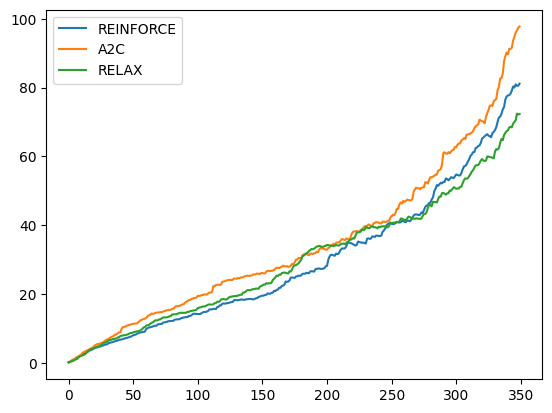

In [ ]:
import matplotlib.pyplot as plt

for algorithm in ['REINFORCE', 'A2C', 'RELAX']:
    plt.plot(algorithm2rewards[algorithm], label = algorithm)
plt.legend()
plt.show()

In [ ]:
algorithm2rewards = {}
for algorithm in ['REINFORCE', 'A2C', 'RELAX']:
    algorithm2rewards[algorithm] = apply_benchmark(algorithm=algorithm,
                                                   env_name='Acrobot-v1',
                                                   max_episode=100)

/home/machenike/my_ML_env/env/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0	Last reward: -513.00	Average reward: -513.00
Episode 25	Last reward: -807.00	Average reward: -503.47
Episode 50	Last reward: -371.00	Average reward: -469.67
Episode 75	Last reward: -228.00	Average reward: -434.18
Episode 100	Last reward: -266.00	Average reward: -395.07
Episode 125	Last reward: -228.00	Average reward: -358.25
Episode 150	Last reward: -187.00	Average reward: -320.26
Episode 175	Last reward: -156.00	Average reward: -287.50
Episode 0	Last reward: -413.00	Average reward: -413.00
Episode 25	Last reward: -377.00	Average reward: -427.33
Episode 50	Last reward: -511.00	Average reward: -424.20
Episode 75	Last reward: -232.00	Average reward: -400.47
Episode 100	Last reward: -125.00	Average reward: -370.11
Episode 125	Last reward: -133.00	Average reward: -337.30
Episode 150	Last reward: -171.00	Average reward: -302.91
Episode 175	Last reward: -126.00	Average reward: -272.56


/tmp/ipykernel_9069/3926159296.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  action_log_prob = F.log_softmax(action_logits)[action]


Episode 0	Last reward: -253.00	Average reward: -253.00


In [ ]:
import matplotlib.pyplot as plt

for algorithm in ['REINFORCE', 'A2C', 'RELAX']:
    plt.plot(algorithm2rewards[algorithm], label = algorithm)
plt.legend()
plt.show()